Script to process KPI time series data:
For train data:
1. Check for missing points in each KPI sequence.
2. Perform linear interpolation for missing points.
3. Split time series based on KPI ID.

For test data:
1. Split time series based on KPI ID.

In [40]:
# Import necessary libraries
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import STL
import warnings
import zipfile

logging.basicConfig(level=logging.INFO)

warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")
plt.rcParams.update(
    {
        "axes.edgecolor": "0.3",
        "axes.linewidth": 0.8,
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "axes.titleweight": "bold",
        "legend.fontsize": 10,
        "figure.dpi": 120,
        "legend.frameon": False,
    }
)

In [41]:
# unzip raw data if not already unzipped
raw_test_data_path = "../../datasets/KPI/raw/phase2_ground_truth.hdf.zip"
raw_train_data_path = "../../datasets/KPI/raw/phase2_train.csv.zip"
test_data_path = "../../datasets/KPI/raw/phase2_ground_truth.hdf"
train_data_path = "../../datasets/KPI/raw/phase2_train.csv"
if not os.path.exists(test_data_path):
    with zipfile.ZipFile(raw_test_data_path, "r") as zip_ref:
        zip_ref.extractall(os.path.dirname(raw_test_data_path))
    print(f"Unzipped raw data to {os.path.dirname(raw_test_data_path)}")
if not os.path.exists(train_data_path):
    with zipfile.ZipFile(raw_train_data_path, "r") as zip_ref:
        zip_ref.extractall(os.path.dirname(raw_train_data_path))
    print(f"Unzipped raw data to {os.path.dirname(raw_train_data_path)}")

# convert test data from hdf to parquet
test_data_path = "../../datasets/KPI/raw/phase2_ground_truth.hdf"
test_data_parquet = "../../datasets/KPI/raw/phase2_ground_truth.parquet"
# If parquet already exists, skip conversion to avoid repeated work
if os.path.exists(test_data_parquet):
    print(f"Parquet already exists: {test_data_parquet}")
else:
    print(f"Reading HDF: {test_data_path}")
    try:
        test_ts = pd.read_hdf(test_data_path)
        # Ensure KPI ID values are safe to serialize (UUIDs -> str)
        if "KPI ID" in test_ts.columns:
            test_ts["KPI ID"] = test_ts["KPI ID"].astype(str)
        test_ts = pl.from_pandas(test_ts)
        test_ts.write_parquet(  # pyright: ignore[reportAttributeAccessIssue]
            test_data_parquet
        )
        print(f"Wrote parquet: {test_data_parquet}")
    except Exception as e:
        print(f"Failed to convert HDF to parquet: {e}")

Parquet already exists: ../../datasets/KPI/raw/phase2_ground_truth.parquet


In [66]:
# Load train and test data
train_data_path = "../../datasets/KPI/raw/phase2_train.csv"
test_data_path = (
    "../../datasets/KPI/raw/phase2_ground_truth.parquet"  # parquet produced above
)
# Use polars for fast IO: CSV for train, parquet for test
kpi_ids = [
    "0efb375b-b902-3661-ab23-9a0bb799f4e3",
    "301c70d8-1630-35ac-8f96-bc1b6f4359ea",
    "c02607e8-7399-3dde-9d28-8a8da5e5d251",
    "e0747cad-8dc8-38a9-a9ab-855b61f5551d",
]
train_ts = (
    pl.read_csv(
        train_data_path,
        schema={
            "timestamp": pl.UInt64,
            "value": pl.Float64,
            "label": pl.UInt8,
            "KPI ID": pl.String,
        },
        truncate_ragged_lines=True,
    )
    .rename({"KPI ID": "ID"})
    .filter(pl.col("ID").is_in(kpi_ids))
)
test_ts = pl.read_parquet(test_data_path)
test_ts = (
    test_ts.with_columns(pl.col("label").cast(pl.UInt8))
    .with_columns(pl.col("timestamp").cast(pl.UInt64))
    .rename({"KPI ID": "ID"})
    .filter(pl.col("ID").is_in(kpi_ids))
)

In [67]:
# Explore train data
print(f"Train data columns: {train_ts.columns}")

print(f"Train data shape: {train_ts.shape}")

print(
    f"Train data has {train_ts['ID'].n_unique()} KPI IDs:\n{train_ts['ID'].unique().to_list()}"
)
train_anomaly_count = train_ts.filter(pl.col("label") == 1).shape[0]
print(
    f"Train data total anomaly points: {train_anomaly_count}, anomaly ratio: {train_anomaly_count / train_ts.shape[0]:.6f}"
)
train_ts.head()

Train data columns: ['timestamp', 'value', 'label', 'ID']
Train data shape: (35136, 4)
Train data has 4 KPI IDs:
['e0747cad-8dc8-38a9-a9ab-855b61f5551d', '0efb375b-b902-3661-ab23-9a0bb799f4e3', 'c02607e8-7399-3dde-9d28-8a8da5e5d251', '301c70d8-1630-35ac-8f96-bc1b6f4359ea']
Train data total anomaly points: 226, anomaly ratio: 0.006432


timestamp,value,label,ID
u64,f64,u8,str
1469376000,0.8473,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"
1469376300,-0.036137,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"
1469376600,0.074292,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"
1469376900,0.074292,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"
1469377200,-0.036137,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"


In [68]:
# Explore test data
print(f"Test data shape: {test_ts.shape}")
print(
    f"Test data has {test_ts['ID'].n_unique()} KPI IDs:\n{test_ts['ID'].unique().to_list()}"
)
test_anomaly_count = test_ts.filter(pl.col("label") == 1).shape[0]
print(
    f"Test data total anomaly points: {test_anomaly_count}, anomaly ratio: {test_anomaly_count / test_ts.shape[0]:.6f}"
)
test_ts.head()

Test data shape: (35136, 4)
Test data has 4 KPI IDs:
['e0747cad-8dc8-38a9-a9ab-855b61f5551d', 'c02607e8-7399-3dde-9d28-8a8da5e5d251', '301c70d8-1630-35ac-8f96-bc1b6f4359ea', '0efb375b-b902-3661-ab23-9a0bb799f4e3']
Test data total anomaly points: 454, anomaly ratio: 0.012921


timestamp,value,label,ID
u64,f64,u8,str
1472011200,0.516011,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"
1472011500,0.626441,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"
1472011800,0.736871,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"
1472012100,0.8473,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"
1472012400,1.06816,0,"""e0747cad-8dc8-38a9-a9ab-855b61…"


In [69]:
# utils for KPI stats
def compute_kpi_stats(df: pl.DataFrame) -> pl.DataFrame:
    """Compute KPI statistics from time series data.

    Args:
        df (pl.DataFrame): Input DataFrame with columns 'KPI ID', 'timestamp', 'value', 'label'.
    Returns:
        pl.DataFrame: DataFrame with computed statistics per 'KPI ID'.
    """
    # Group by 'KPI ID' and compute statistics
    return (
        df.group_by("ID")
        .agg(
            [
                pl.count().alias("Points"),
                ((pl.col("label") == 1).sum()).alias("Anomaly Points"),
                # Interval calculation
                pl.col("timestamp")
                .diff()
                .median()
                .cast(pl.UInt32)
                .alias("Interval (s)"),
                # Calculate expected points directly in aggregation
                (
                    (
                        (pl.col("timestamp").max() - pl.col("timestamp").min())
                        / pl.col("timestamp").diff().median()
                    )
                    + 1
                )
                .cast(pl.UInt32)
                .alias("Expected Points"),
                pl.col("timestamp")
                .diff()
                .map_batches(
                    lambda intervals: pl.Series(
                        [
                            ((intervals / intervals.median()).round() - 1)
                            .filter((intervals / intervals.median()).round() - 1 > 0)
                            .min()
                            or 0
                        ],
                        dtype=pl.Int32,
                        strict=False,
                    )
                )
                .first()
                .alias("Gap | Min"),
                pl.col("timestamp")
                .diff()
                .cast(pl.UInt32)
                .map_batches(
                    lambda intervals: pl.Series(
                        [
                            ((intervals / intervals.median()).round() - 1)
                            .filter((intervals / intervals.median()).round() - 1 > 0)
                            .median()
                            or 0
                        ],
                        dtype=pl.Int32,
                        strict=False,
                    )
                )
                .first()
                .alias("Gap | Median"),
                pl.col("timestamp")
                .diff()
                .cast(pl.UInt32)
                .map_batches(
                    lambda intervals: pl.Series(
                        [
                            ((intervals / intervals.median()).round() - 1)
                            .filter((intervals / intervals.median()).round() - 1 > 0)
                            .max()
                            or 0
                        ],
                        dtype=pl.Int32,
                        strict=False,
                    )
                )
                .first()
                .alias("Gap | Max"),
            ]
        )
        .with_columns(
            pl.col("ID").str.slice(0, 8),
            # Calculate missing points
            pl.when(pl.col("Interval (s)").is_not_null())
            .then((pl.col("Expected Points") - pl.col("Points")).clip(lower_bound=0))
            .otherwise(0)
            .cast(pl.UInt32)
            .alias("Missing Points"),
        )
        .with_columns(
            # Calculate missing rate and anomaly rate
            (100 * pl.col("Missing Points") / pl.col("Expected Points"))
            .fill_null(0)
            .round(2)
            .alias("Missing Rate (%)"),
            (100 * pl.col("Anomaly Points") / pl.col("Points"))
            .fill_null(0)
            .round(2)
            .alias("Anomaly Rate (%)"),
        )
        .select(
            [
                "ID",
                "Points",
                "Interval (s)",
                "Missing Points",
                # "Missing Rate (%)",
                # "Gap | Min",
                # "Gap | Max",
                # "Gap | Median",
                "Anomaly Points",
                "Anomaly Rate (%)",
            ]
        )
        .sort("ID")
    )

In [70]:
# Explore train time series per KPI ID.
train_ts = train_ts.sort(["ID", "timestamp"])

train_stats = compute_kpi_stats(train_ts)
train_stats

ID,Points,Interval (s),Missing Points,Anomaly Points,Anomaly Rate (%)
str,u32,u32,u32,u32,f64
"""0efb375b""",8784,300,0,13,0.15
"""301c70d8""",8784,300,0,114,1.3
"""c02607e8""",8784,300,0,6,0.07
"""e0747cad""",8784,300,0,93,1.06


In [71]:
# Explore test time series per KPI ID.
test_ts = test_ts.sort(["ID", "timestamp"])

test_stats = compute_kpi_stats(test_ts)
test_stats

ID,Points,Interval (s),Missing Points,Anomaly Points,Anomaly Rate (%)
str,u32,u32,u32,u32,f64
"""0efb375b""",8784,300,0,71,0.81
"""301c70d8""",8784,300,0,206,2.35
"""c02607e8""",8784,300,0,61,0.69
"""e0747cad""",8784,300,0,116,1.32


In [72]:
kpi_ids = train_stats.filter(pl.col("Missing Points") == 0)["ID"].to_list()
kpi_ids

['0efb375b', '301c70d8', 'c02607e8', 'e0747cad']

In [73]:
train_stats.filter(pl.col("Missing Points") == 0).select(
    ["ID", "Points", "Interval (s)", "Anomaly Points", "Anomaly Rate (%)"]
)

ID,Points,Interval (s),Anomaly Points,Anomaly Rate (%)
str,u32,u32,u32,f64
"""0efb375b""",8784,300,13,0.15
"""301c70d8""",8784,300,114,1.3
"""c02607e8""",8784,300,6,0.07
"""e0747cad""",8784,300,93,1.06


In [74]:
test_stats.filter(pl.col("Missing Points") == 0).select(
    ["ID", "Points", "Interval (s)", "Anomaly Points", "Anomaly Rate (%)"]
)

ID,Points,Interval (s),Anomaly Points,Anomaly Rate (%)
str,u32,u32,u32,f64
"""0efb375b""",8784,300,71,0.81
"""301c70d8""",8784,300,206,2.35
"""c02607e8""",8784,300,61,0.69
"""e0747cad""",8784,300,116,1.32


In [75]:
# Function to fill missing time points with linear interpolation
def fill_missing_points_with_nan(df: pl.DataFrame) -> pl.DataFrame:
    """
    Fill missing time points for each KPI with NaN values.
    Much faster than Python-loop-based method.
    """

    results = []
    print("Filling missing points for each KPI ...")

    # Process each KPI ID separately
    for kpi_id in df["KPI ID"].unique():
        kpi_ts = df.filter(pl.col("KPI ID") == kpi_id).sort("timestamp")

        # Skip KPIs with less than 2 points
        if kpi_ts.height < 2:
            results.append(kpi_ts)
            continue

        # Calculate interval (median)
        timestamps = kpi_ts["timestamp"]
        interval = int(np.median(np.diff(timestamps)))

        start_time = int(timestamps[0])
        end_time = int(timestamps[-1])

        # Generate complete timestamp sequence (Polars natively supports arange)
        complete_timestamps = pl.arange(
            start_time,
            end_time + interval,
            step=interval,
            eager=True,
        )
        completed = pl.DataFrame(
            {
                "timestamp": complete_timestamps,
                "KPI ID": [kpi_id] * len(complete_timestamps),
            }
        )

        # Use left join to fill missing points
        completed = completed.join(kpi_ts, on=["KPI ID", "timestamp"], how="left")
        completed = completed.with_columns(pl.col("label").fill_null(0))

        # Statistics
        missing_added = completed.height - kpi_ts.height
        if missing_added > 0:
            print(
                f"   KPI {kpi_id[:8]}: {kpi_ts.height} -> {completed.height} (Added {missing_added} NaN points)"
            )

        results.append(completed)

    # Concatenate all KPIs
    df = pl.concat(results).sort(["KPI ID", "timestamp"])

    # Validation info
    total_missing = df["value"].is_null().sum()
    print(f"Completed {len(results)} KPIs, total missing points added: {total_missing}")
    # tag missing value
    df = df.with_columns(pl.col("value").is_null().alias("missing"))
    return df

In [76]:
# train_ts = fill_missing_points_with_nan(train_ts)
# only keep KPIs with no missing points
train_ts = train_ts.filter(pl.col("ID").str.slice(0, 8).is_in(kpi_ids))
compute_kpi_stats(train_ts)

ID,Points,Interval (s),Missing Points,Anomaly Points,Anomaly Rate (%)
str,u32,u32,u32,u32,f64
"""0efb375b""",8784,300,0,13,0.15
"""301c70d8""",8784,300,0,114,1.3
"""c02607e8""",8784,300,0,6,0.07
"""e0747cad""",8784,300,0,93,1.06


In [77]:
# test_ts = fill_missing_points_with_nan(test_ts)
test_ts = test_ts.filter(pl.col("ID").str.slice(0, 8).is_in(kpi_ids))
compute_kpi_stats(test_ts)

ID,Points,Interval (s),Missing Points,Anomaly Points,Anomaly Rate (%)
str,u32,u32,u32,u32,f64
"""0efb375b""",8784,300,0,71,0.81
"""301c70d8""",8784,300,0,206,2.35
"""c02607e8""",8784,300,0,61,0.69
"""e0747cad""",8784,300,0,116,1.32


In [53]:
def stl_interpolation(values: pl.Series, period=24, robust=True):
    """
    STL (Seasonal-Trend decomposition using Loess) based interpolation.

    Best for data with clear seasonal patterns and trends.

    Args:
        series: pl.Series with missing values (NaN)
        period: Seasonal period (e.g., 1440 for daily pattern with 1-min interval)
        robust: Whether to use robust fitting

    Returns:
        pl.Series with filled values
    """
    if values.is_null().sum() == 0:
        return values
    v = values.to_pandas()

    # First pass: linear interpolation for initial decomposition
    filled = v.interpolate(method="linear", limit_direction="both")

    # Check if we have enough data points for STL
    if len(filled) < 2 * period:
        print(
            f"   Warning: Series too short for STL (len={len(filled)}, period={period}). Using linear interpolation."
        )
        return values.interpolate(method="linear")

    try:
        # STL decomposition
        stl = STL(filled, period=period, seasonal=13, robust=robust)
        result = stl.fit()

        # Reconstruct series from components
        reconstructed = result.trend + result.seasonal

        # Fill only the originally missing positions
        missing = v.isna()
        filled[missing] = reconstructed[missing]

        return pl.Series(filled)

    except Exception as e:
        print(f"   STL failed: {e}. Falling back to linear interpolation.")
        return values.interpolate(method="linear")

In [54]:
def visualize_missing_segments_comparison(
    df: pl.DataFrame,
    min_missing=10,
    max_missing=100,
    n_samples=3,
):
    """
    Visualize multiple filling strategies, ensuring every point aligns with the x-axis (timestamp).
    """

    for col in ["KPI ID", "timestamp", "value", "label"]:
        assert col in df.columns, f"Missing column: {col}"

    kpis = df.group_by("KPI ID").agg(
        pl.col("value").is_null().sum().alias("missing_count")
    )
    candidate_kpis = kpis.filter(pl.col("missing_count") > 0)["KPI ID"].to_list()
    chosen_segments = []

    for kpi_id in candidate_kpis:
        kpi_ts = df.filter(pl.col("KPI ID") == kpi_id).sort("timestamp")
        value = kpi_ts["value"]
        nan_mask = value.is_null().to_numpy()
        diff = np.diff(np.concatenate(([0], nan_mask.view(np.int8), [0])))
        starts = np.where(diff == 1)[0]
        ends = np.where(diff == -1)[0]
        for s, e in zip(starts, ends):
            length = e - s
            if min_missing <= length <= max_missing:
                chosen_segments.append((kpi_id, s, e))
                break
        if len(chosen_segments) >= n_samples:
            break

    if not chosen_segments:
        print("No suitable missing segments found.")
        return

    print(f"Found {len(chosen_segments)} missing segments for visualization.")

    _, axes = plt.subplots(
        len(chosen_segments), 1, figsize=(12, 4.5 * len(chosen_segments))
    )
    if len(chosen_segments) == 1:
        axes = [axes]

    colors = {
        "linear": "#0072B2",
        "forward": "#009E73",
        "backward": "#D55E00",
        "mean": "#CC79A7",
        "zero": "#A9A9A9",
        "max": "#E69F00",
        "min": "#56B4E9",
        "stl": "#8B008B",
        "knn": "#20B2AA",
    }

    for ax, (kpi_id, s, e) in zip(axes, chosen_segments):
        kpi_ts = df.filter(pl.col("KPI ID") == kpi_id).sort("timestamp")

        filled = kpi_ts.with_columns(
            [
                pl.col("value").interpolate().alias("linear"),
                pl.col("value").fill_null(strategy="forward").alias("forward"),
                pl.col("value").fill_null(strategy="backward").alias("backward"),
                pl.col("value").fill_null(strategy="mean").alias("mean"),
                pl.col("value").fill_null(strategy="min").alias("min"),
                pl.col("value").fill_null(strategy="max").alias("max"),
                pl.col("value").fill_null(strategy="zero").alias("zero"),
            ]
        )

        value = filled["value"].to_numpy()
        x = pd.to_datetime(filled["timestamp"].to_numpy(), unit="s")
        y_methods = {
            col: filled[col].to_numpy()
            for col in filled.columns
            if col not in ["KPI ID", "timestamp", "label"]
        }

        pad = int(e - s)
        start = max(0, s - pad)
        end = min(len(value), e + pad)

        x = x[start:end]
        y_true = value[start:end]
        y_methods = {k: v[start:end] for k, v in y_methods.items()}

        y_knn = (
            KNNImputer()
            .fit_transform(kpi_ts["value"].to_numpy().reshape(-1, 1))
            .flatten()
        )

        y_stl = stl_interpolation(kpi_ts["value"], period=24).to_numpy()

        y_methods["knn"] = y_knn[start:end]
        y_methods["stl"] = y_stl[start:end]

        for method, y in y_methods.items():
            ax.plot(
                x,
                y,
                "o-",
                lw=2,
                label=method.capitalize(),
                color=colors.get(method, "gray"),
            )

        y_original = kpi_ts["value"].to_numpy()[start:end]
        ax.plot(
            x,
            y_original,
            "o-",
            color="black",
            lw=1.5,
            label="Original (NaN)",
            alpha=0.6,
        )

        ax.axvspan(
            x[pad - 1], x[-pad], color="gray", alpha=0.15, label="Missing segment"
        )

        plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
        ax.set_title(f"KPI: {kpi_id} | Missing segment [{s}-{e}] ({e - s} points)")
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("Value")
        ax.legend(loc="best", fontsize=8)
        sns.despine(ax=ax)

    plt.tight_layout()
    plt.show()

Found 3 missing segments for visualization.


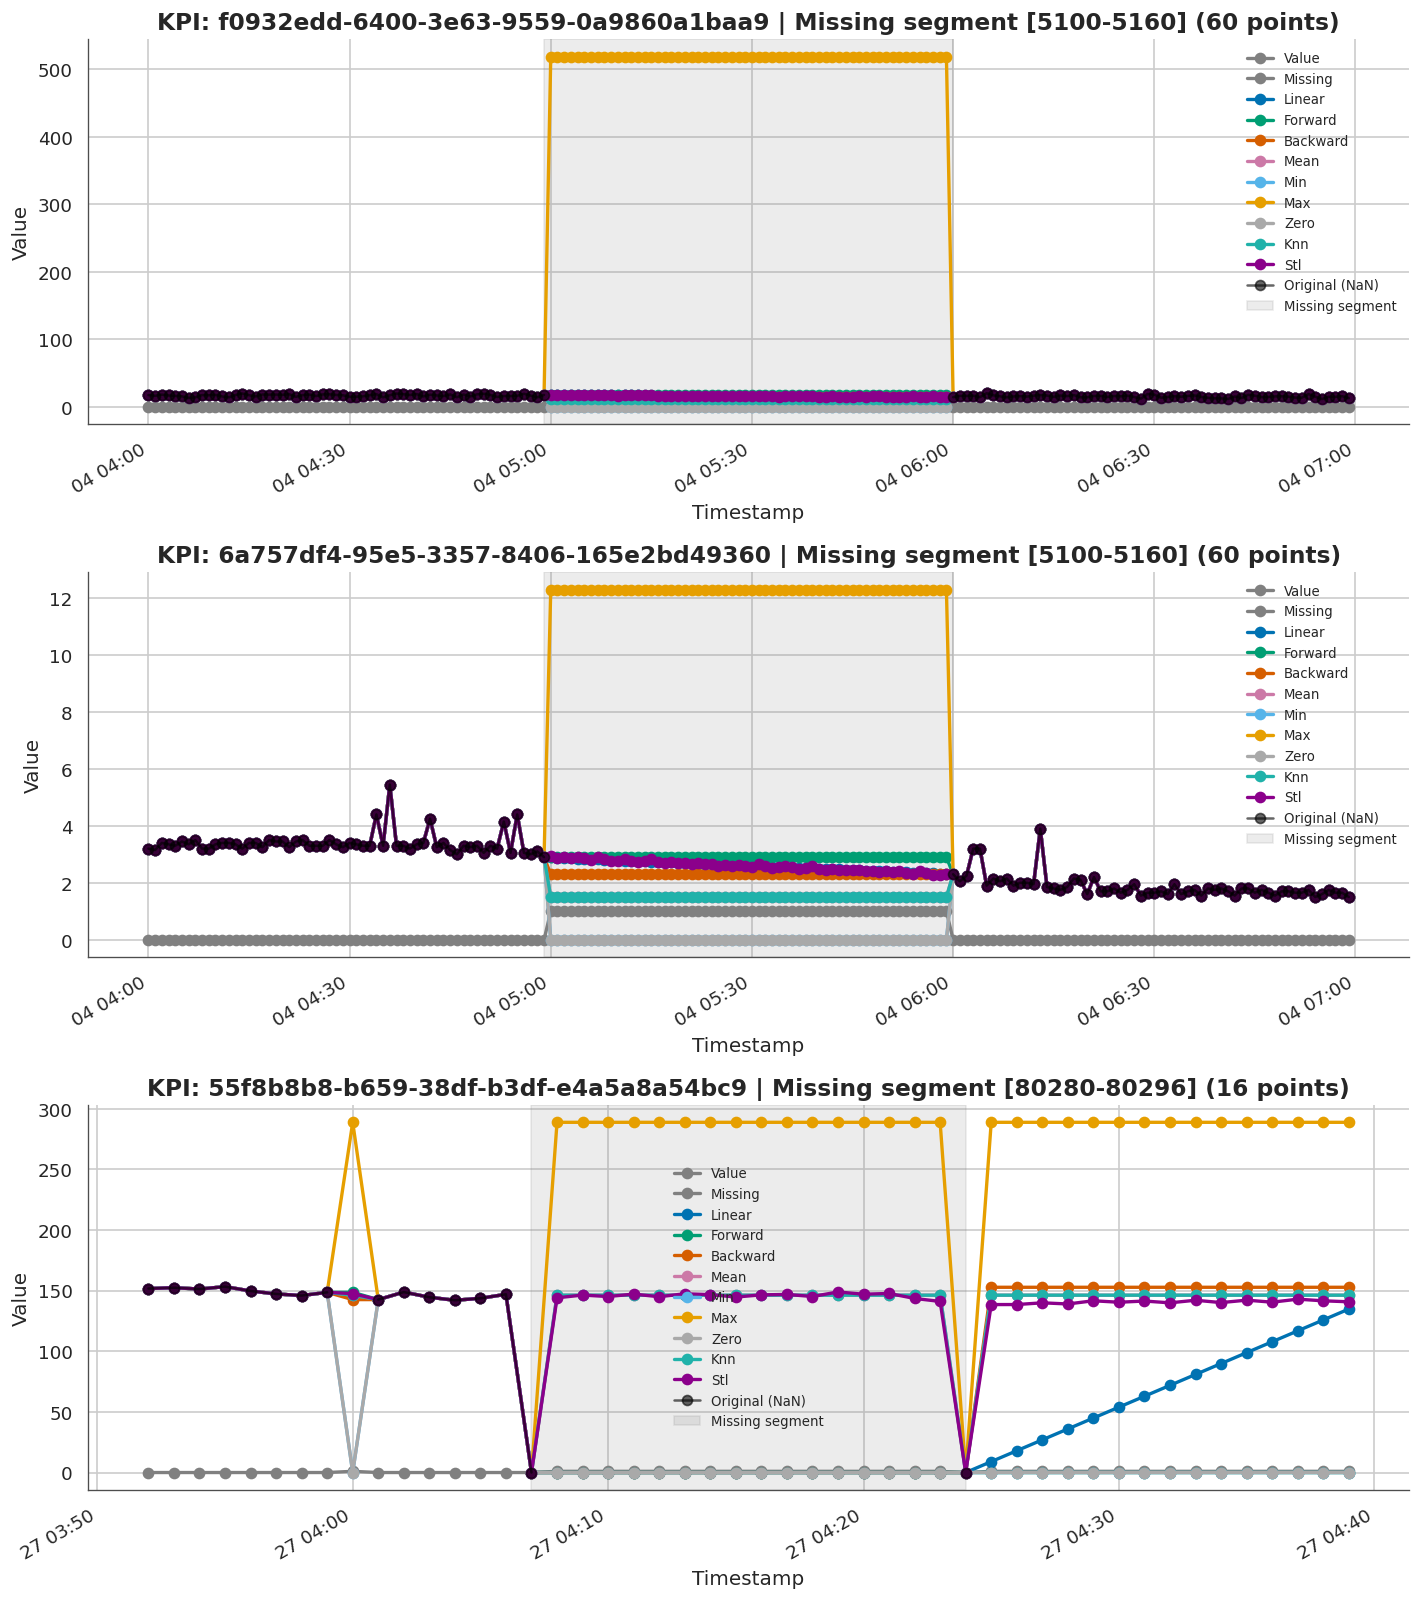

In [55]:
visualize_missing_segments_comparison(
    train_ts, min_missing=10, max_missing=100, n_samples=3
)

In [56]:
# Interpolate missing values using STL interpolation for train and test data


def apply_stl_interpolation(df: pl.DataFrame, period: int = 1440) -> pl.DataFrame:
    """
    Apply STL interpolation to fill missing values for each KPI.

    Args:
        df: Polars DataFrame with columns ['KPI ID', 'timestamp', 'value', 'label']
        period: Seasonal period for STL (e.g., 1440 for daily pattern with 1-min interval)

    Returns:
        DataFrame with filled values
    """
    results = []
    print(f"Applying STL interpolation to {df['KPI ID'].n_unique()} KPIs...")

    for kpi_id in df["KPI ID"].unique():
        kpi_ts = df.filter(pl.col("KPI ID") == kpi_id).sort("timestamp")

        # Skip if no missing values
        if kpi_ts["value"].is_null().sum() == 0:
            results.append(kpi_ts)
            continue

        missing = kpi_ts["value"].is_null().sum()

        # Apply STL interpolation
        filled_values = stl_interpolation(kpi_ts["value"], period=period)

        # Update the dataframe with filled values
        kpi_ts = kpi_ts.with_columns(filled_values.alias("value"))

        filled_count = missing - kpi_ts["value"].is_null().sum()
        if filled_count > 0:
            print(
                f"   KPI {kpi_id[:8]}: Filled {filled_count}/{missing} missing points using STL"
            )

        results.append(kpi_ts)

    filled = pl.concat(results).sort(["KPI ID", "timestamp"])
    total_filled = df["value"].is_null().sum() - filled["value"].is_null().sum()
    print(f"Total missing points filled: {total_filled}")

    return filled


# Apply STL interpolation to train data
print("Processing TRAIN data with STL interpolation...")
# train_ts = apply_stl_interpolation(train_ts, period=1440)
train_ts = train_ts.with_columns(pl.col("value").interpolate())

print("Processing TEST data with STL interpolation...")
# test_ts = apply_stl_interpolation(test_ts, period=1440)
test_ts = test_ts.with_columns(pl.col("value").interpolate())

Processing TRAIN data with STL interpolation...
Processing TEST data with STL interpolation...


In [79]:
# seperate train ts into multiple csv files based on KPI ID
kpi_ids = train_ts["ID"].unique().to_list()
output_dir = "../../datasets/KPI/train"
if os.path.exists(output_dir):
    for f in os.listdir(output_dir):
        os.remove(os.path.join(output_dir, f))
else:
    os.makedirs(output_dir, exist_ok=True)
for kpi_id in kpi_ids:
    kpi_ts = (
        train_ts.filter(pl.col("ID") == kpi_id)
        .sort("timestamp")
        .select(["timestamp", "value", "label"])
    )
    output_path = os.path.join(output_dir, f"{kpi_id}.csv")
    kpi_ts.write_csv(output_path)
    print(f"Wrote KPI {kpi_id} to {output_path}")
sample = train_ts.filter(pl.col("ID") == kpi_ids[0]).select(
    ["timestamp", "value", "label"]
)
sample.head()

Wrote KPI 0efb375b-b902-3661-ab23-9a0bb799f4e3 to ../../datasets/KPI/train/0efb375b-b902-3661-ab23-9a0bb799f4e3.csv
Wrote KPI c02607e8-7399-3dde-9d28-8a8da5e5d251 to ../../datasets/KPI/train/c02607e8-7399-3dde-9d28-8a8da5e5d251.csv
Wrote KPI 301c70d8-1630-35ac-8f96-bc1b6f4359ea to ../../datasets/KPI/train/301c70d8-1630-35ac-8f96-bc1b6f4359ea.csv
Wrote KPI e0747cad-8dc8-38a9-a9ab-855b61f5551d to ../../datasets/KPI/train/e0747cad-8dc8-38a9-a9ab-855b61f5551d.csv


timestamp,value,label
u64,f64,u8
1472918400,0.234191,0
1472918700,0.236657,0
1472919000,0.230887,0
1472919300,0.217486,0
1472919600,0.223722,0


In [80]:
output_dir = "../../datasets/KPI/test"
if os.path.exists(output_dir):
    for f in os.listdir(output_dir):
        os.remove(os.path.join(output_dir, f))
else:
    os.makedirs(output_dir, exist_ok=True)
for kpi_id in kpi_ids:
    kpi_ts = (
        test_ts.filter(pl.col("ID") == kpi_id)
        .sort("timestamp")
        .select(["timestamp", "value", "label"])
    )
    output_path = os.path.join(output_dir, f"{kpi_id}.csv")
    kpi_ts.write_csv(output_path)
    print(f"Wrote KPI {kpi_id} to {output_path}")
sample = train_ts.filter(pl.col("ID") == kpi_ids[0]).select(
    ["timestamp", "value", "label"]
)
sample.head()

Wrote KPI 0efb375b-b902-3661-ab23-9a0bb799f4e3 to ../../datasets/KPI/test/0efb375b-b902-3661-ab23-9a0bb799f4e3.csv
Wrote KPI c02607e8-7399-3dde-9d28-8a8da5e5d251 to ../../datasets/KPI/test/c02607e8-7399-3dde-9d28-8a8da5e5d251.csv
Wrote KPI 301c70d8-1630-35ac-8f96-bc1b6f4359ea to ../../datasets/KPI/test/301c70d8-1630-35ac-8f96-bc1b6f4359ea.csv
Wrote KPI e0747cad-8dc8-38a9-a9ab-855b61f5551d to ../../datasets/KPI/test/e0747cad-8dc8-38a9-a9ab-855b61f5551d.csv


timestamp,value,label
u64,f64,u8
1472918400,0.234191,0
1472918700,0.236657,0
1472919000,0.230887,0
1472919300,0.217486,0
1472919600,0.223722,0


In [93]:
# 可视化函数：针对不同KPI绘制时间序列图（修复异常点对齐问题）
def plot_kpi_timeseries(
    df: pl.DataFrame, kpi_ids: list, dataset_name: str, figsize=(20, 12)
):
    """
    绘制多个KPI的时间序列图，标记异常点

    Args:
        df: DataFrame with columns ['timestamp', 'value', 'label', 'ID']
        kpi_ids: List of KPI IDs to plot
        dataset_name: 'Train' or 'Test'
        figsize: Figure size
    """
    n_kpis = len(kpi_ids)
    fig, axes = plt.subplots(n_kpis, 1, figsize=figsize)

    if n_kpis == 1:
        axes = [axes]

    for idx, (ax, kpi_id) in enumerate(zip(axes, kpi_ids)):
        # 筛选当前KPI的数据
        kpi_data = df.filter(pl.col("ID") == kpi_id).sort("timestamp")

        if kpi_data.height == 0:
            ax.text(
                0.5,
                0.5,
                f"No data for KPI {kpi_id[:8]}",
                ha="center",
                va="center",
                transform=ax.transAxes,
            )
            continue

        # 转换时间戳为datetime
        timestamps = pd.to_datetime(kpi_data["timestamp"].to_numpy(), unit="s")
        values = kpi_data["value"].to_numpy()
        labels = kpi_data["label"].to_numpy()

        # 分离正常点和异常点
        anomaly_mask = labels == 1

        # ✅ 关键修复：先绘制整条完整的线（包括所有点）
        ax.plot(
            timestamps,
            values,
            color="#2E86AB",
            linewidth=1.5,
            label="Normal",
            alpha=0.8,
        )

        # ✅ 然后在异常点位置用红色圆圈标记（叠加在线上）
        if anomaly_mask.sum() > 0:
            ax.scatter(
                timestamps[anomaly_mask],
                values[anomaly_mask],
                color="#E63946",
                s=20,  # 调小标记大小
                marker="o",
                label="Anomaly",
                zorder=5,
                edgecolors="darkred",
                linewidths=1.2,
                alpha=0.9,
            )

        # 设置标题和标签
        kpi_short = kpi_id[:8]
        anomaly_count = anomaly_mask.sum()
        anomaly_rate = anomaly_count / len(labels) * 100

        ax.set_title(
            f"{dataset_name} - ID: {kpi_short} | "
            f"Points: {len(values):,} | "
            f"Anomalies: {anomaly_count} ({anomaly_rate:.2f}%)",
            fontsize=14,
            fontweight="bold",
            pad=10,
        )

        ax.set_xlabel("Timestamp", fontsize=12, fontweight="bold")
        ax.set_ylabel("Value", fontsize=12, fontweight="bold")

        # 美化图表
        ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.5)
        ax.legend(loc="upper right", fontsize=10, framealpha=0.9)

        # 格式化x轴日期显示
        import matplotlib.dates as mdates

        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())

        # 旋转x轴标签
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

        # 去除顶部和右侧边框
        sns.despine(ax=ax)

        # 添加统计信息文本框
        stats_text = f"Mean: {values.mean():.4f}\nStd: {values.std():.4f}"
        ax.text(
            0.02,
            0.98,
            stats_text,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
        )

    plt.tight_layout()
    return fig


# 获取所有KPI ID（完整版本）
kpi_ids_full = train_ts["ID"].unique().to_list()
print(f"Found {len(kpi_ids_full)} KPI IDs")
print(f"KPI IDs: {[kpi[:8] for kpi in kpi_ids_full]}")

Found 4 KPI IDs
KPI IDs: ['0efb375b', 'e0747cad', 'c02607e8', '301c70d8']


Plotting Training Set Time Series


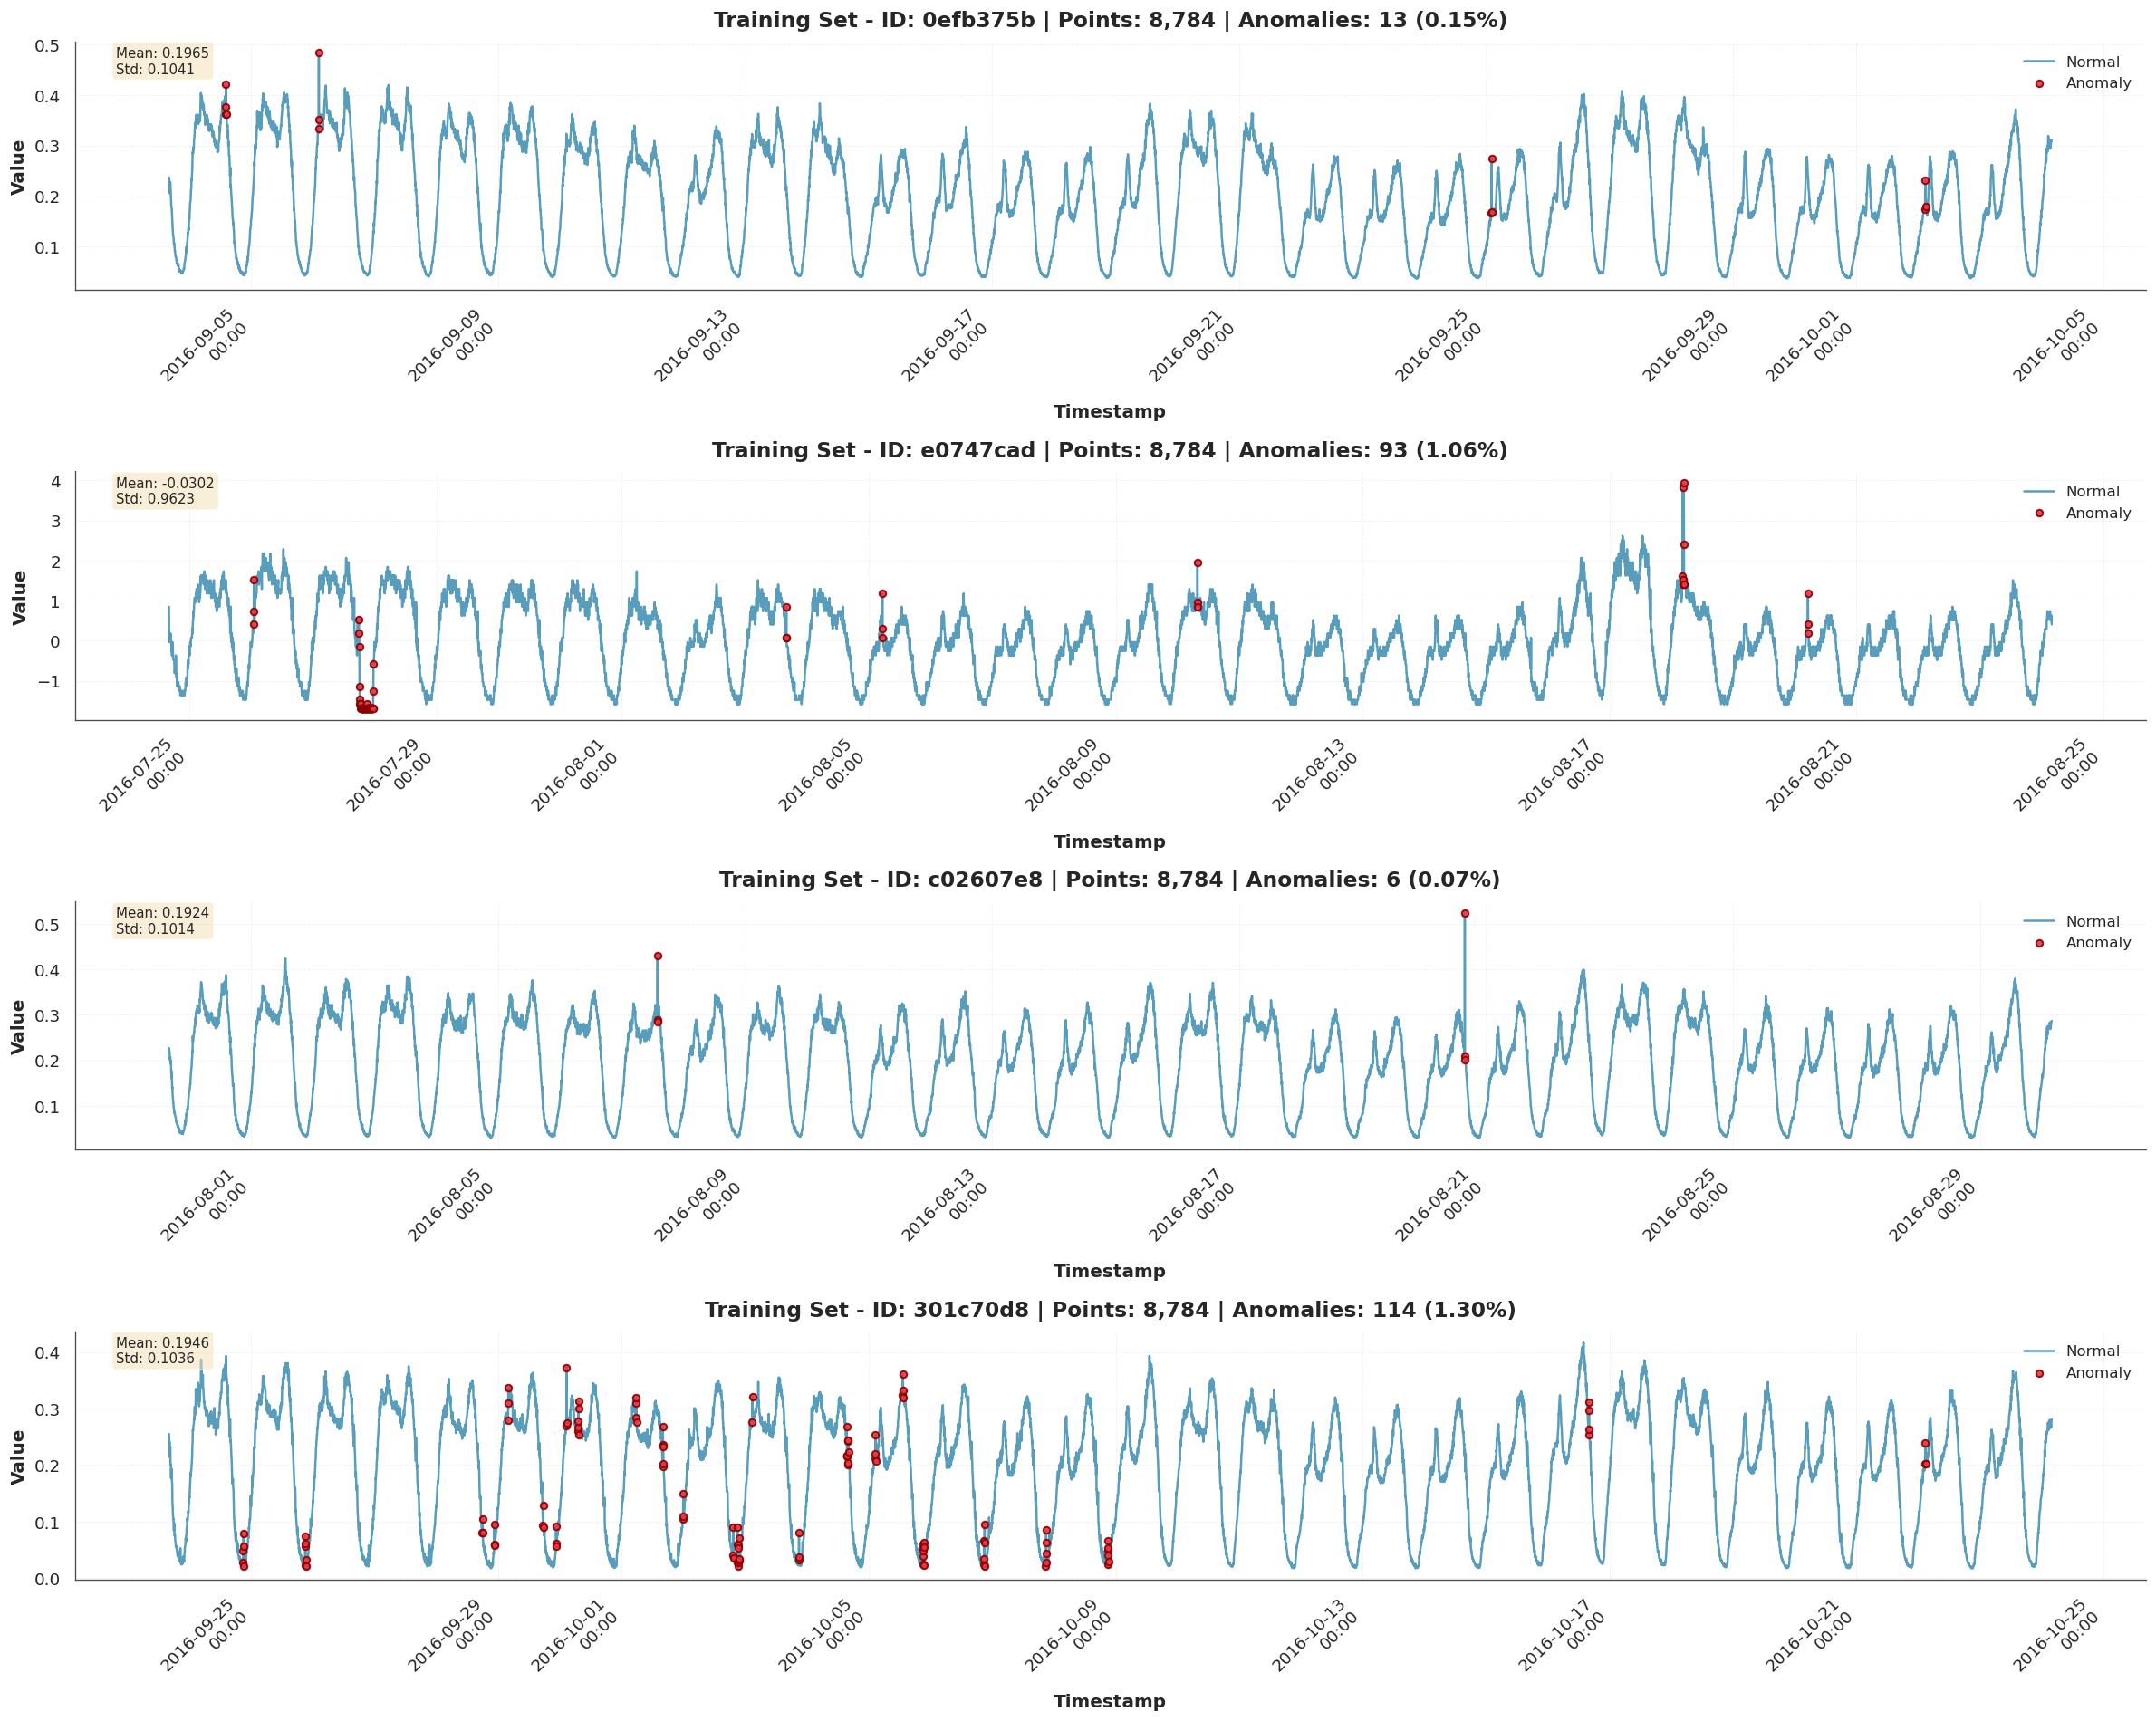


Training set visualization completed!


In [94]:
# 绘制训练集时间序列图（4个KPI在一张大图中）
print("=" * 60)
print("Plotting Training Set Time Series")
print("=" * 60)

fig_train = plot_kpi_timeseries(
    df=train_ts,
    kpi_ids=kpi_ids_full,
    dataset_name="Training Set",
    figsize=(20, 16),  # 4个子图，每个约4的高度
)

plt.show()
print("\nTraining set visualization completed!")

Plotting Test Set Time Series


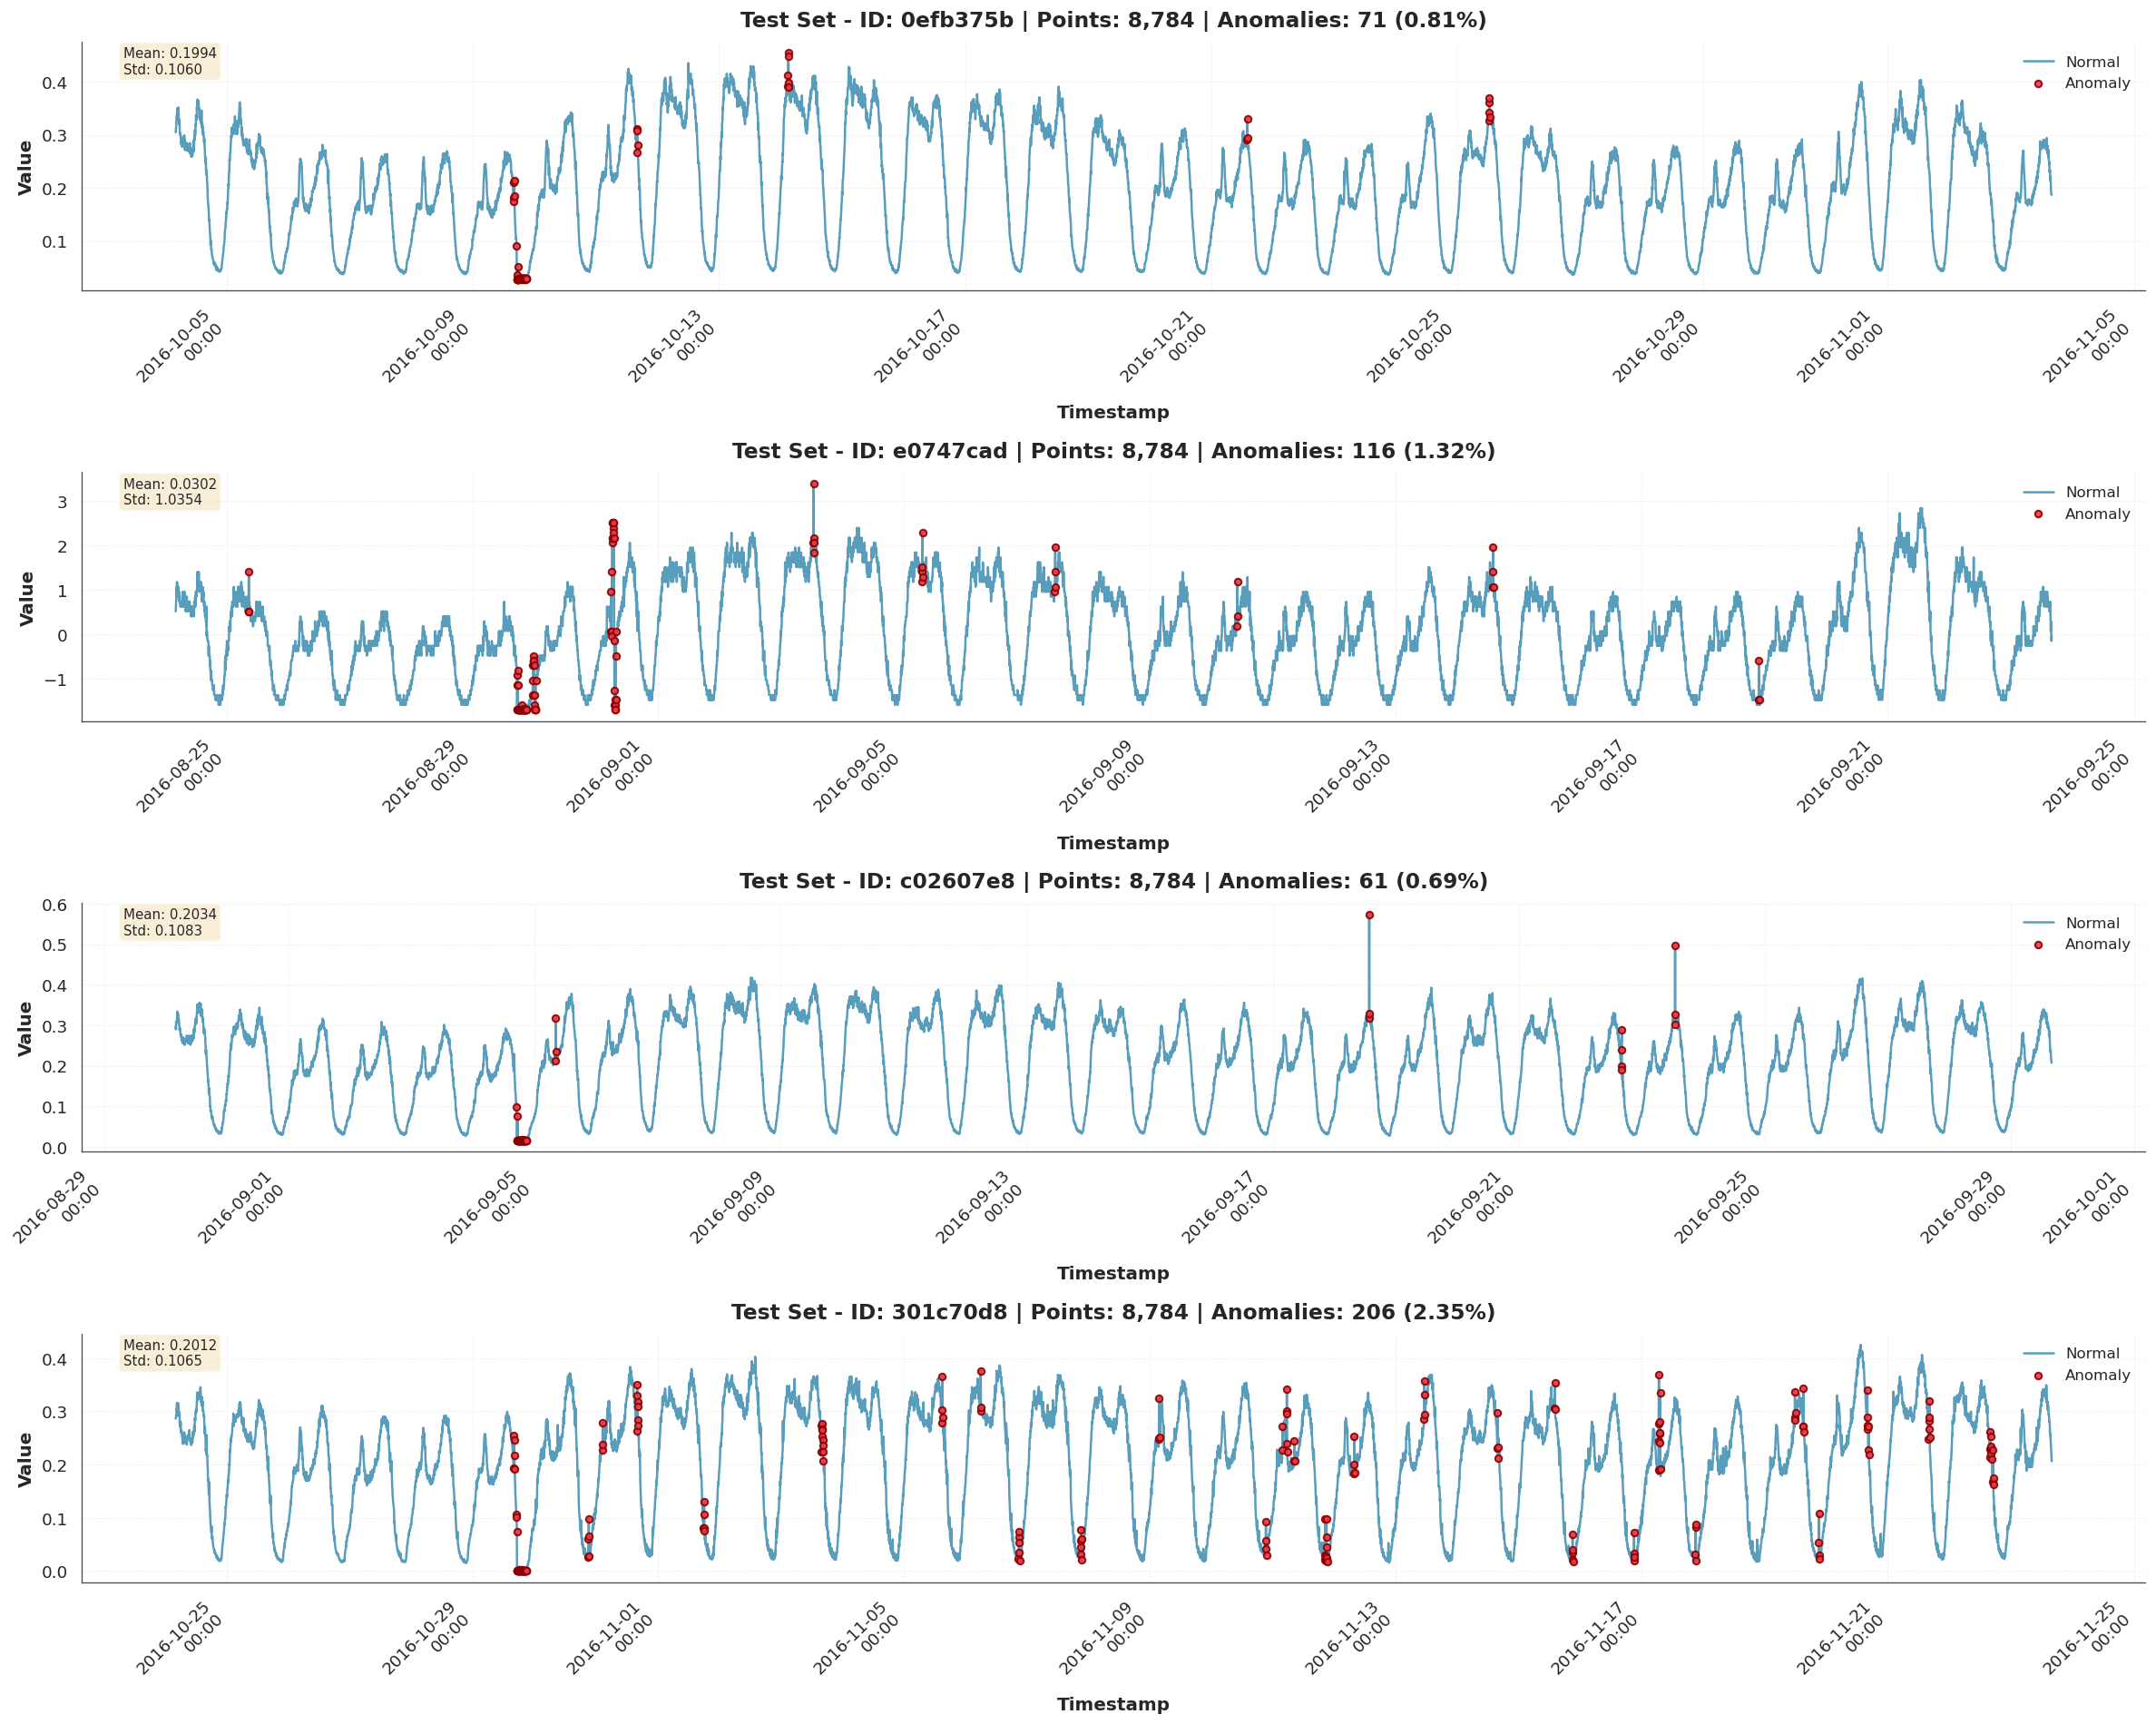


Test set visualization completed!


In [95]:
# 绘制测试集时间序列图（4个KPI在一张大图中）
print("=" * 60)
print("Plotting Test Set Time Series")
print("=" * 60)

fig_test = plot_kpi_timeseries(
    df=test_ts,
    kpi_ids=kpi_ids_full,
    dataset_name="Test Set",
    figsize=(20, 16),  # 4个子图，每个约4的高度
)

plt.show()
print("\nTest set visualization completed!")

In [ ]:
# 可选：每个KPI训练集和测试集并排对比（修复异常点对齐）
def plot_train_test_comparison(train_df, test_df, kpi_ids, figsize=(24, 16)):
    """
    训练集和测试集并排对比图（异常点在曲线上）
    """
    n_kpis = len(kpi_ids)
    fig, axes = plt.subplots(n_kpis, 2, figsize=figsize)

    for idx, kpi_id in enumerate(kpi_ids):
        # 训练集（左列）
        ax_train = axes[idx, 0]
        train_data = train_df.filter(pl.col("ID") == kpi_id).sort("timestamp")

        if train_data.height > 0:
            timestamps = pd.to_datetime(train_data["timestamp"].to_numpy(), unit="s")
            values = train_data["value"].to_numpy()
            labels = train_data["label"].to_numpy()

            anomaly_mask = labels == 1

            # ✅ 先画完整的线
            ax_train.plot(
                timestamps,
                values,
                color="#2E86AB",
                linewidth=1.5,
                alpha=0.8,
                label="Normal",
            )

            # ✅ 异常点叠加在线上
            if anomaly_mask.sum() > 0:
                ax_train.scatter(
                    timestamps[anomaly_mask],
                    values[anomaly_mask],
                    color="#E63946",
                    s=35,
                    marker="o",
                    zorder=5,  # 调小标记
                    edgecolors="darkred",
                    linewidths=1.0,
                    label="Anomaly",
                )

            ax_train.set_title(
                f"Train - {kpi_id[:8]} | Anomalies: {anomaly_mask.sum()}",
                fontsize=12,
                fontweight="bold",
            )
            ax_train.set_ylabel("Value", fontsize=11, fontweight="bold")
            ax_train.grid(True, alpha=0.3, linestyle="--", linewidth=0.5)
            ax_train.legend(loc="upper right", fontsize=9)

            import matplotlib.dates as mdates

            ax_train.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
            plt.setp(ax_train.get_xticklabels(), rotation=45, ha="right")

        # 测试集（右列）
        ax_test = axes[idx, 1]
        test_data = test_df.filter(pl.col("ID") == kpi_id).sort("timestamp")

        if test_data.height > 0:
            timestamps = pd.to_datetime(test_data["timestamp"].to_numpy(), unit="s")
            values = test_data["value"].to_numpy()
            labels = test_data["label"].to_numpy()

            anomaly_mask = labels == 1

            # ✅ 先画完整的线
            ax_test.plot(
                timestamps,
                values,
                color="#06A77D",
                linewidth=1.5,
                alpha=0.8,
                label="Normal",
            )

            # ✅ 异常点叠加在线上
            if anomaly_mask.sum() > 0:
                ax_test.scatter(
                    timestamps[anomaly_mask],
                    values[anomaly_mask],
                    color="#E63946",
                    s=35,
                    marker="o",
                    zorder=5,  # 调小标记
                    edgecolors="darkred",
                    linewidths=1.0,
                    label="Anomaly",
                )

            ax_test.set_title(
                f"Test - {kpi_id[:8]} | Anomalies: {anomaly_mask.sum()}",
                fontsize=12,
                fontweight="bold",
            )
            ax_test.set_ylabel("Value", fontsize=11, fontweight="bold")
            ax_test.grid(True, alpha=0.3, linestyle="--", linewidth=0.5)
            ax_test.legend(loc="upper right", fontsize=9)

            import matplotlib.dates as mdates

            ax_test.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
            plt.setp(ax_test.get_xticklabels(), rotation=45, ha="right")

        # 去除边框
        sns.despine(ax=ax_train)
        sns.despine(ax=ax_test)

    # 添加总标题
    fig.suptitle(
        "Training vs Test Set Comparison", fontsize=16, fontweight="bold", y=0.995
    )

    plt.tight_layout()
    return fig


print("=" * 60)
print("Plotting Training vs Test Comparison (8 subplots)")
print("=" * 60)

fig_comparison = plot_train_test_comparison(
    train_df=train_ts, test_df=test_ts, kpi_ids=kpi_ids_full, figsize=(24, 18)
)

plt.show()
print("\nComparison visualization completed!")

In [ ]:
# 可选：保存图片
output_dir = "../../datasets/KPI/figures"
os.makedirs(output_dir, exist_ok=True)

# 重新生成并保存训练集图
print("Saving training set figure...")
fig_train = plot_kpi_timeseries(
    train_ts, kpi_ids_full, "Training Set", figsize=(20, 16)
)
fig_train.savefig(
    os.path.join(output_dir, "train_timeseries.png"), dpi=150, bbox_inches="tight"
)
plt.close(fig_train)

# 重新生成并保存测试集图
print("Saving test set figure...")
fig_test = plot_kpi_timeseries(test_ts, kpi_ids_full, "Test Set", figsize=(20, 16))
fig_test.savefig(
    os.path.join(output_dir, "test_timeseries.png"), dpi=150, bbox_inches="tight"
)
plt.close(fig_test)

# 保存对比图
print("Saving comparison figure...")
fig_comp = plot_train_test_comparison(train_ts, test_ts, kpi_ids_full, figsize=(24, 18))
fig_comp.savefig(
    os.path.join(output_dir, "train_test_comparison.png"), dpi=150, bbox_inches="tight"
)
plt.close(fig_comp)

print(f"\n✓ All figures saved to: {output_dir}")
print(f"  - train_timeseries.png")
print(f"  - test_timeseries.png")
print(f"  - train_test_comparison.png")